In [43]:
import numpy as np
import scipy.optimize as opt
import pylab as plt
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import math

In [60]:
kB = 0.695 #boltzmans constant in wavenumber units per kelvin (cm^-1/K)
T = 300 #K. Completely random. Can change to whatever
k=0.025 #time step. Can change as desired
runs=500
output_runs=np.full((runs,1),0.000)
for x in range (0,runs):
    latticeE=np.random.normal(11000, 500, size=(4, 4)) #random lattice
    latticeE = np.rint(latticeE) #rounding to nearest integer for simplicity
    W2=np.full((16,16),0.000)#initializing to zero
    P1=np.full((len(W2),1),0.0625) #initial distribution
    
    #Setting up W2 matrix
    lengthInner=len(latticeE[0])
    lengthOuter=len(latticeE)
    rowCounter = 0
    for i in range (0,len(latticeE)): #This loop is defining the nearest neighbors
        for j in range (0,len(latticeE)):
            if (j==0 or j==lengthInner-1):
                neighborWrap = j + ((lengthInner-1) * (1 if j==0 else -1))
                neighborNonWrap = j + (1 if j==0 else -1)
                neighborLeft = neighborWrap if (j==0) else neighborNonWrap
                neighborRight = neighborNonWrap if (j==0) else neighborWrap
            else:
                neighborLeft = j - 1
                neighborRight = j + 1
            if (i==0 or i==lengthOuter-1):
                neighborWrap = i + ((lengthOuter-1) * (1 if i==0 else -1))
                neighborNonWrap = i + (1 if i==0 else -1)
                neighborUp = neighborWrap if (i==0) else neighborNonWrap
                neighborDown = neighborNonWrap if (i==0) else neighborWrap
            else:
                neighborUp = i - 1
                neighborDown = i + 1
            iLeft = (i * len(latticeE)) + neighborLeft
            iRight = (i * len(latticeE)) + neighborRight
            iUp = (neighborUp * len(latticeE)) + j
            iDown = (neighborDown * len(latticeE)) + j #After this we enter the probabilities depending on neighbors to W2
            W2[iLeft][rowCounter] = math.exp(-(latticeE[i][neighborLeft]-latticeE[i][j])/(kB*T)) if (latticeE[i][neighborLeft] > latticeE[i][j]) else 1
            W2[iRight][rowCounter] = math.exp(-(latticeE[i][neighborRight]-latticeE[i][j])/(kB*T)) if (latticeE[i][neighborRight] > latticeE[i][j]) else 1
            W2[iUp][rowCounter] = math.exp(-(latticeE[neighborUp][j]-latticeE[i][j])/(kB*T)) if (latticeE[neighborUp][j] > latticeE[i][j]) else 1
            W2[iDown][rowCounter] = math.exp(-(latticeE[neighborDown][j]-latticeE[i][j])/(kB*T)) if (latticeE[neighborDown][j] > latticeE[i][j]) else 1
            rowCounter += 1
    
    W2=k*W2 #adding in factor of k 
    for i in range (0, len(W2)): #diagonal elements once the transitions are calculated and scaled by k
        for j in range(0, len(W2)):
            if (i == j):
                W2[i][j] = 1-np.sum(W2, axis=0)[i] 
    
    #Boltz 
    Boltz=np.full((len(W2),1),0.000) #initializing boltzman dist as zero, then 
    LatticeList= latticeE.ravel()
    Plist=np.full((len(W2),1),0.000) #empty list for boltzman, will divide by partition function for Boltz
    for i in range (0,len(LatticeList)):
        p_i = math.exp(-(LatticeList[i])/(kB*T))
        Plist[i]=p_i

    for i in range (0,len(LatticeList)):
        Q= np.sum(Plist, axis=0) #partition function

    for i in range (0,len(LatticeList)):
        Boltz[i]= Plist[i]/Q  
    #we have P1, we apply W2 (the matrix) to get P2 and so on. Do that until Pn = Boltz 
    arr = P1
    boundLimit = 0.001 #how close each element of Pn must be to Boltz values 
    notWithinBounds = True
    ctr = 0
    while notWithinBounds:
        arrInBounds = True
        for i in range (0, len(arr)):
            if (abs(arr[i]-Boltz[i]) > boundLimit):
                arrInBounds = False
                break
        if not(arrInBounds):
            arr = W2 @ arr
            ctr = ctr + 1
        else:
            notWithinBounds = False
        output_runs[x]=ctr
    


    


In [61]:
for i in range(0,runs):
    Tot= np.sum(output_runs, axis=0)
avg_runs=Tot/runs
print(avg_runs)

std_dev=np.std(output_runs)
print(std_dev)

[4291.696]
12388.721960379287


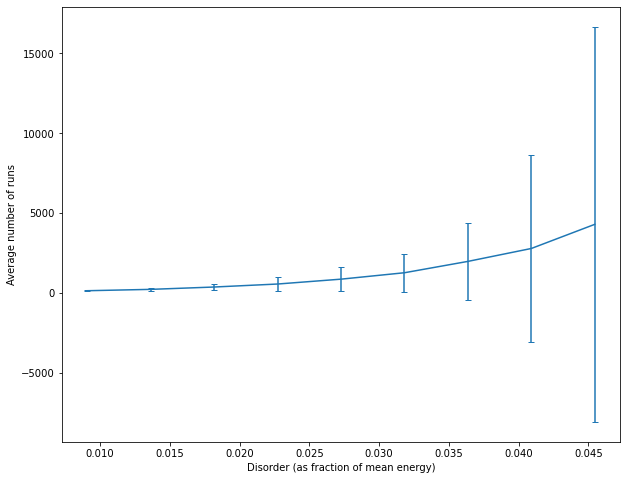

In [76]:
#graphing avgs,std devs versus ratio of disorder to mean energy
disorder1=np.array([100,150,200,250,300,350,400,450,500])
disorder=disorder1/11000
avgs=np.array([132.82,217.97,364.99,552.76,857.61,1259.86,1970.56,2779.63,4291.70])
stds=([44.65,99.02,211.18,422.72,740.78,1185.66,2418.98,5872.99,12388.72])
fig, ax = plt.subplots(figsize = (10,8))
ax.errorbar(disorder, avgs,stds, capsize = 3)
ax.set_xlabel("Disorder (as fraction of mean energy)")
ax.set_ylabel("Average number of runs")
plt.show()